In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# Import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import math
from scipy import stats, optimize
import numpy as np

import time
from tqdm import tqdm
from datetime import timedelta
from typing import Callable, Dict, List, Optional, Sequence, Tuple, Type, Union
import warnings

In [3]:
from _position_pnl_trace import *
from column_names import *
from _data_preprocessing import *
from _stats import *

In [4]:
df_hs300 = pd.read_csv('data.csv')

# reformat df
df_hs300['instrument'] = 'HS300'
df_hs300.set_index(['Unnamed: 0', 'instrument'], inplace = True)
df_hs300.index.set_names({'Unnamed: 0': 'human_readable_timestamp'}, inplace = True)

time_format = '%Y-%m-%d %H:%M:%S'
df_hs300.index.set_levels(
    [pd.to_datetime(df_hs300.index.get_level_values('human_readable_timestamp'), format = time_format)],
    level=['human_readable_timestamp'], inplace=True)

df_hs300 = df_hs300[['open', 'close', 'high', 'low']].apply(pd.to_numeric)

/var/folders/hq/g8_lqrgd5k5c0rbyg245xr380000gn/T/ipykernel_7475/4262441887.py:9: FutureWarning: inplace is deprecated and will be removed in a future version.
  df_hs300.index.set_levels(


In [5]:
df_hs300.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 314280 entries, (Timestamp('2010-04-16 09:16:00'), 'HS300') to (Timestamp('2015-01-30 15:15:00'), 'HS300')
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    314280 non-null  float64
 1   close   314280 non-null  float64
 2   high    314280 non-null  float64
 3   low     314280 non-null  float64
dtypes: float64(4)
memory usage: 21.6+ MB


In [6]:
df_hs300.sort_index(level = 'human_readable_timestamp', ascending = True, inplace = True)

In [7]:
def create_observation_windows(obs_list_str, first_pd_timestamp, time_window_size):
    date_str = str(first_pd_timestamp.date())
    
    # first observation window
    out = [(first_pd_timestamp, first_pd_timestamp + timedelta(minutes = time_window_size-1))]
    
    if len(obs_list_str) == 0:
        return out
    
    for start, end in obs_list_str:
        start_pd = pd.Timestamp(f'{date_str} {start}')
        if not end:
            end_pd = start_pd + timedelta(minutes = time_window_size-1)
        else:
            end_pd = pd.Timestamp(f'{date_str} {end}')
        out.append((start_pd, end_pd))
    
    return out

def create_trading_windows(observation_windows, end_of_trading_list_str, end_pd_timestamp):
    date_str = str(end_pd_timestamp.date())
    out = []
    
    for obs_start, obs_end in observation_windows:
        if end_of_trading_list_str:
            out.append(
                (obs_end + timedelta(minutes=1), pd.Timestamp(f'{date_str} {end_of_trading_list_str.pop(0)}'))
            )
                       
    out.append((obs_end + timedelta(minutes=1), end_pd_timestamp))
    return out

def data_query_by_time(start, end, data):
    cond1 = data.index.get_level_values('human_readable_timestamp') >= start
    cond2 = data.index.get_level_values('human_readable_timestamp') <= end 
    return data[cond1 & cond2]


def intraday_drawdown_signal(signal_series):
    return (1.0 - (signal_series[::-1].cummin() / signal_series)).values

def intraday_reverse_drawdown_signal(signal_series):
    return (signal_series[::-1].cummax() / signal_series - 1.0).values

def emotional_stability(dd, dd_reverse):
    return min(dd.mean(), dd_reverse.mean())


def generate_intraday_signal_parameters(observation_windows, df):
    
    '''
        {observation time window: 
            avg_dd: float,
            reverse_avg_dd: float,
            emotional_index: float,
            open_price: float
            }
    '''
    
    out = {}
    for obs_win in observation_windows:
        obs_df = data_query_by_time(obs_win[0], obs_win[1], df)
        
        # calculate pointwise drawdown signals
        ptw_dd, ptw_reverse_dd = intraday_drawdown_signal(obs_df.close), intraday_reverse_drawdown_signal(obs_df.close)
        
        # compute emotional index
        mean_dd, mean_reverse_dd = ptw_dd.mean(), ptw_reverse_dd.mean()
        emotional_index = min(mean_dd, mean_reverse_dd)
        
        trade_start_timestamp = obs_win[1] + timedelta(minutes = 1)
        out[trade_start_timestamp] = {
            'avg_dd': mean_dd,
            'reverse_avg_dd': mean_reverse_dd,
            'emotional_index': emotional_index,
            'open_price': obs_df.open.iloc[0] # open price at start of observation window
        }
        
    return out


def generate_dataframe_of_signal_parameters(pars):
    iterables = [[],[]] # first to save date, second to save time
    pars_list = []
    for t, ps in pars.items():
        # set index
        date = t.date() 
        time_of_day = str(t).split(' ')[1]
        
        if len(iterables[0]) == 0:
            iterables[0].append(date)
        iterables[1].append(time_of_day)

        pars_list.append([ps['avg_dd'], ps['reverse_avg_dd'], ps['emotional_index']]) # columns

    index = pd.MultiIndex.from_product(iterables, names=["date", "trading_start_time"])
    
    return pd.DataFrame(pars_list,
                        columns = ['average_drawdown', 'average_reverse_drawdown', 'emotional_index'],
                        index = index)

In [8]:
def generate_trade_from_signal(df, trade_windows, signal_pars, stop_loss_threshold, emo_index_threshold):

    trade_size_vec = np.zeros(len(df))
    trade_windows_copy = trade_windows[:]
    
    loop_index = 0 
    trade_start, trade_close = trade_windows_copy.pop(0)
    trade_flag, trade_force_to_close_sl = False, False
    
    for row_index, row in df.iterrows():
        curr_t = row_index[0]
        
        # close current trade window 
        if (curr_t == trade_close and trade_flag) or trade_force_to_close_sl:
            if trade_direction == 'long':
                trade_size_vec[loop_index] = -1
            else:
                trade_size_vec[loop_index] = 1
            # reset for next round
            trade_flag, trade_force_to_close_sl = False, False
            if trade_windows_copy: trade_start, trade_close = trade_windows_copy.pop(0)
        
        if curr_t == trade_start:
            # decide either open and how to trade 
            if signal_pars[trade_start]['emotional_index'] < emo_index_threshold:
                trade_price = row.open
                if row.open > signal_pars[trade_start]['open_price']: # long
                    trade_direction = 'long'
                    trade_size_vec[loop_index] = 1   
                else:
                    trade_direction = 'short'
                    trade_size_vec[loop_index] = -1
                trade_flag = True # flag trading window
            else: # go to the next availiable trade 
                if trade_windows_copy: trade_start, trade_close = trade_windows_copy.pop(0)

        # track pnl percentage in trading window
        if trade_flag:
            pnl_perct = (row.close - trade_price) / trade_price
            if trade_direction == 'short':
                pnl_perct *= -1
            if pnl_perct < -stop_loss_threshold:
                trade_force_to_close_sl = True # close trade due to pnl loss

        loop_index += 1
        
    return trade_size_vec

In [9]:
def generate_trade_book(strategy_config, df_price_raw):
    
    df = df_price_raw.copy()
    
    # assign model parameters
    emo_index_threshold = strategy_config['emo_index_threshold']
    transaction_cost_perct = strategy_config['transaction_cost_perct']
    stop_loss_threshold_perct = strategy_config['stop_loss_threshold_perct']
    observation_durations = strategy_config['observation_durations']
    observation_size = strategy_config['observation_window_size']
    end_of_trading_times = strategy_config['end_of_trading_times']

    grouping = [lambda x: x[0].date()] # grouping = [lambda x: x[0].year, lambda x: x[0].month, lambda x: x[0].day]
    df_groups = df.groupby(grouping)
    df_signal_list = []
    
    for i, g in tqdm(df_groups, desc = 'signal and trade processing'):
        time.sleep(0.0001)
        
        start_of_day_timestamp, end_of_day_timestamp = g.index[0][0], g.index[-1][0]

        # generate observation and trading windows (pass in copy of list!)
        observation_windows = create_observation_windows(observation_durations[:], start_of_day_timestamp, observation_size)
        trade_windows = create_trading_windows(observation_windows, end_of_trading_times[:], end_of_day_timestamp)
        
        # generate key signal parameters
        pars = generate_intraday_signal_parameters(observation_windows, g)
        df_signal_list.append(generate_dataframe_of_signal_parameters(pars))

        # get size
        df.loc[g.index, TRADE_SIZE] = generate_trade_from_signal(g, trade_windows, pars,
                                                                 stop_loss_threshold_perct, emo_index_threshold)
            
    df_signal_all = pd.concat(df_signal_list, axis=0) # signal parameters
    df[TRADE_PRICE] = df.open.values
    
    return df.copy(), df_signal_all.copy()

In [10]:
strategy_config = {
    'observation_durations': [ # observation windows beside [open, open + 50mins]
        ('11:12:00', '13:32:00')],
    'observation_window_size': 50, # 50 mins for observation size
    'end_of_trading_times': ['11:30:00'], # ending of each trading windows, note that start of each trading window is: end of obs + 1min
    'emo_index_threshold': 9 / 10000.,
    'transaction_cost_perct': 1 / 10000.,
    'stop_loss_threshold_perct': 0.5 / 100.
}

strategy_config_simple = {
    'observation_durations': [],
    'observation_window_size': 50, # 50 mins for observation size
    'end_of_trading_times': [], # ending of each trading windows, note that start of each trading window is: end of obs + 1min
    'emo_index_threshold': 9 / 10000.,
    'transaction_cost_perct': 1 / 10000.,
    'stop_loss_threshold_perct': 0.5 / 100.
}

In [11]:
df_hs300_trade_intraday, signal_df = generate_trade_book(strategy_config, df_hs300)

df_hs300_trade_intraday_simple, signal_df_simple = generate_trade_book(strategy_config_simple, df_hs300)

signal and trade processing: 100%|██████████| 1164/1164 [00:16<00:00, 70.00it/s]


### From intraday trade trace (sequence of buy and sell) to calculate position and pnl columns 

Tally PnL at some time $t$ in a day ($p_{t}$ is the asset market price at $t$, $q_{i}$ and $p_{i}$ are the size and price for trade $i$)
$$Pnl(t) = \sum_{i \in \{\text{trades before time t}\}} q_{i} (p_{t} - p_{i}) = p_{t} \left[\sum_{i \in \{\text{trades before time t}\}} q_{i}\right] - \sum_{i \in \{\text{trades before time t}\}} q_{i}p_{i}$$

In [12]:
df_hs300_trade_intraday['AM_PM'] = np.fromiter(
    map(
        lambda x: 1 if x.hour <= 12 else 0,
        list(df_hs300_trade_intraday.index.get_level_values('human_readable_timestamp'))
    ),
    dtype = int
)

In [13]:
grouping_day_am_pm = [lambda x: x[0].date(), 'AM_PM']
df_hs300_book_intraday_am_pm = PositionPnLBookIntraday(df_hs300_trade_intraday,
                                                       strategy_config['transaction_cost_perct'],
                                                       grouping_day_am_pm).run()


grouping_day = [lambda x: x[0].date()]
df_hs300_book_intraday_am_pm_simple = PositionPnLBookIntraday(df_hs300_trade_intraday_simple,
                                                       strategy_config_simple['transaction_cost_perct'],
                                                       grouping_day).run()

pnl trace processing: 100%|████████████████| 1164/1164 [00:08<00:00, 142.77it/s]


In [14]:
def from_am_pm_pnl_to_day_pnl(g, scale = None):
    # default is percentage: (1+a)(1+b) = 1+a+b+ab
    if not scale: 
        return g.pnl_net_perct[0] + g.pnl_net_perct[1] + g.pnl_net_perct[0]*g.pnl_net_perct[1]
    
    if scale.upper() == 'DOLLAR': 
        return g.pnl_net_perct[0] + g.pnl_net_perct[1]
    
def from_am_pm_pnl_to_day_pnl_series(df_series, scale = None):
    df_am_pm = pd.DataFrame(df_series)
    df_am_pm.index.names = ['date', 'AM_PM']
    return df_am_pm.groupby('date').apply(from_am_pm_pnl_to_day_pnl)

In [15]:
net_pnl_perct_day_series = from_am_pm_pnl_to_day_pnl_series(
    df_hs300_book_intraday_am_pm.groupby(grouping_day_am_pm)['pnl_net_perct'].last()
)

net_pnl_perct_day_series_simple = df_hs300_book_intraday_am_pm_simple.groupby(grouping_day)['pnl_net_perct'].last()

In [16]:
StatsOfDayPnLBook(net_pnl_perct_day_series).run_stats()

cumulative final return [%]  :  264.19
annual return [%]  :  32.29
max drawdown [%]  :  -6.69
average_drawdown [%]  :  -1.59
sharpe ratio  :  2.45
calmar ratio  :  4.83
value at risk [%]  :  -0.7


,metrics
cumulative final return [%],264.193537
annual return [%],32.289549
max drawdown [%],-6.691528
average_drawdown [%],-1.589991
sharpe ratio,2.452051
calmar ratio,4.825437
value at risk [%],-0.696526


In [17]:
StatsOfDayPnLBook(net_pnl_perct_day_series_simple).run_stats()

cumulative final return [%]  :  228.79
annual return [%]  :  29.39
max drawdown [%]  :  -5.11
average_drawdown [%]  :  -1.12
sharpe ratio  :  2.38
calmar ratio  :  5.75
value at risk [%]  :  -0.59


,metrics
cumulative final return [%],228.785145
annual return [%],29.392417
max drawdown [%],-5.109131
average_drawdown [%],-1.120510
sharpe ratio,2.377734
calmar ratio,5.752919
value at risk [%],-0.594342


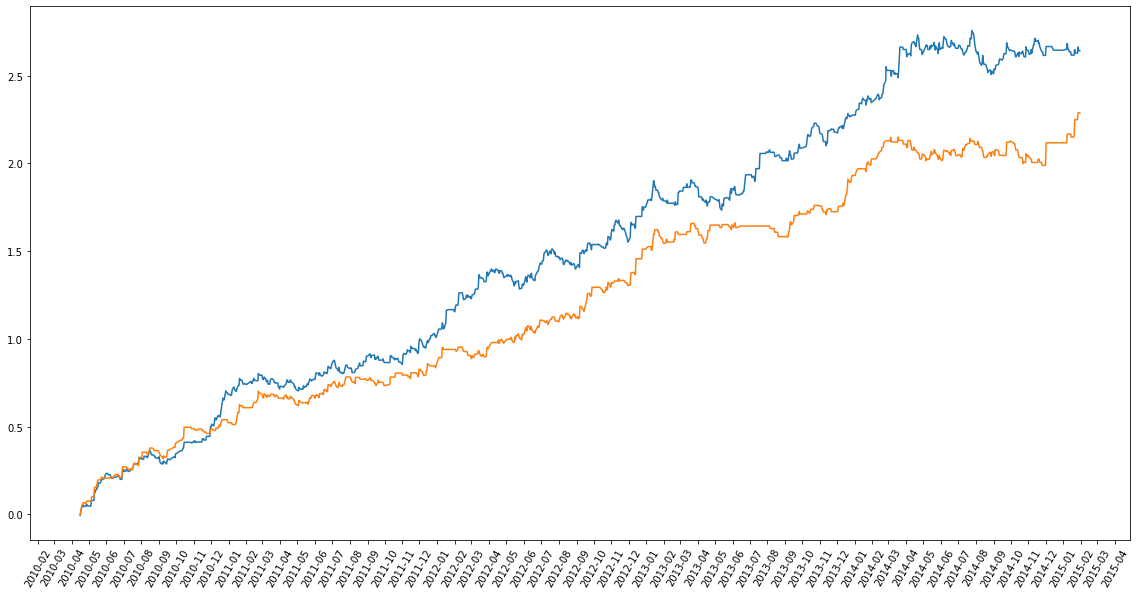

In [21]:
import matplotlib.dates as mdates
import matplotlib
fig, ax = plt.subplots(figsize = (16, 8))
fig.tight_layout()
ax.plot(net_pnl_perct_day_series.index, cum_returns(net_pnl_perct_day_series)-1)
ax.plot(net_pnl_perct_day_series_simple.index, cum_returns(net_pnl_perct_day_series_simple) - 1)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
plt.xticks(rotation=60)

plt.show()

<AxesSubplot:xlabel='human_readable_timestamp,instrument'>

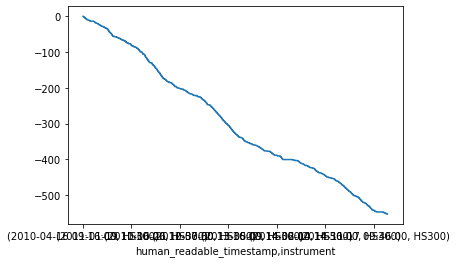

In [611]:
df_hs300_xx.pnl_cost.cumsum().plot()

<AxesSubplot:>

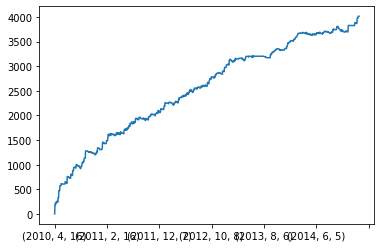

In [612]:
df_hs300_xx.groupby(grouping)['pnl_net'].last().cumsum().plot()

In [536]:
yy[yy > 0]

2010  4   19    0.052704
          21    0.012939
          27    0.014108
          28    0.000751
      5   6     0.028423
                  ...   
2014  11  19    0.002974
      12  2     0.045732
2015  1   8     0.016001
          21    0.030436
          27    0.011037
Name: pnl_net_perct, Length: 263, dtype: float64

In [537]:
yy[yy < 0]

2010  4   26   -0.003421
      5   5    -0.004667
          25   -0.002996
      6   22   -0.002255
          23   -0.004356
                  ...   
2014  11  6    -0.001830
          7    -0.004090
          21   -0.002795
          25   -0.004461
2015  1   15   -0.004214
Name: pnl_net_perct, Length: 267, dtype: float64

In [495]:
259 + 277

536

In [148]:
(152 + 97) / (324 + 196)

0.47884615384615387

In [367]:
324 + 196

520

<AxesSubplot:>

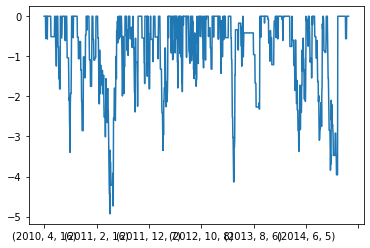

In [333]:
drawdown(yy).plot()

In [135]:
df_hs300_xx.groupby(grouping)['pnl_net'].last()

2010  4  16      0.0
         19    176.6
         20      0.0
         21     43.2
         22    -28.6
               ...  
2015  1  26      0.0
         27     38.8
         28      0.0
         29      0.0
         30      0.0
Name: pnl_net, Length: 1164, dtype: float64

In [136]:
intraday_drawdown_signal(df_hs300_xx.groupby(grouping)['pnl_net'].last())

array([nan,  0., -1., ..., -1., -1., -1.])

In [137]:
df_hs300_xx.groupby(grouping)['pnl_net'].last()

2010  4  16      0.0
         19    176.6
         20      0.0
         21     43.2
         22    -28.6
               ...  
2015  1  26      0.0
         27     38.8
         28      0.0
         29      0.0
         30      0.0
Name: pnl_net, Length: 1164, dtype: float64

In [67]:
cond = (df_hs300_xx['position_open'] != 0)
df_hs300_xx[cond].iloc[0]

open                                     3201.2
close                                    3192.2
high                                     3204.8
low                                      3189.0
trade_signal_trade_allowed_intraday         0.0
trade_signal_drawdown                       0.0
trade_signal_drawdown_reverse              -0.0
trade_signal_observation_period             1.0
trade_signal_emotional_stability       0.000571
trade_signal_direction                    short
trade_size                                  0.0
position_open                               1.0
position_tally                              0.0
position_net                                1.0
trade type                             no trade
is_open_trade                                 0
pnl_open                                  -27.4
pnl_tally                                   0.0
pnl_net                                   -27.4
valuation_open_trade                        0.0
valuation_open_position                 

In [81]:
df_hs300_xx[df_hs300_xx.index.get_level_values('human_readable_timestamp') == '2010-04-26 15:14:00'].iloc[0]

open                                       3219.8
close                                      3220.4
high                                       3222.2
low                                        3219.8
trade_signal_trade_allowed_intraday           1.0
trade_signal_drawdown                   -0.009534
trade_signal_drawdown_reverse            -0.00168
trade_signal_observation_period               0.0
trade_signal_emotional_stability         0.000444
trade_signal_direction                      short
trade_size                                    1.0
position_open                                 0.0
position_tally                                1.0
position_net                                  1.0
trade type                             open trade
is_open_trade                                   1
pnl_open                                     -0.0
pnl_tally                                   -18.0
pnl_net                                     -18.0
valuation_open_trade                          9.0


In [82]:
def query_data_by_day(start, end, data):
    cond1 = data.index.get_level_values('human_readable_timestamp') > start
    cond2 = data.index.get_level_values('human_readable_timestamp') < end 
    return data[cond1 & cond2]

In [513]:
df1 = query_data_by_day('2010-04-19 00:00:00', '2010-04-19 10:05:00', df_hs300_xx)

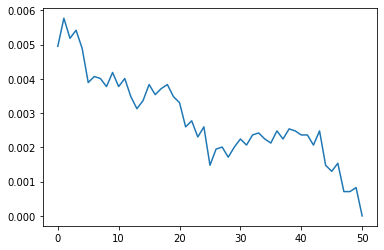

In [512]:
plt.plot(intraday_drawdown_signal(df1.close))

In [666]:
def calculate_emotional_stability1(data):
    length_of_data = len(data)

    max_sum = 0.0  # 最大回撤求和
    min_sum = 0.0  # 反向最大回撤求和
    for i_value in range(0, length_of_data):
        close_i = data.iloc[i_value]["close"]
        max_value = 0.0  # 计算一分钟的最大回撤
        min_value = 0.0  # 计算一分钟的反向最大回撤
        for j_value in range(i_value + 1, length_of_data):
            close_j = data.iloc[j_value]["close"]

            calculate_result = 1 - close_j / close_i

            if calculate_result > max_value:
                max_value = calculate_result

            if calculate_result < min_value:
                min_value = calculate_result

        max_sum += max_value  # 把每一分钟的最大回撤相加
        min_sum += -min_value  # 把每一分钟的反向最大回撤相加（注意取负值）

    max_ave = max_sum / length_of_data  # 平均最大回撤
    min_ave = min_sum / length_of_data  # 平均最大反向回撤

    print("平均最大回撤：" + str(max_ave))
    print("平均最大反向回撤：" + str(min_ave))

    # 比较平均最大回撤和平均最大反向回撤，哪个小就返回哪个
    if max_ave <= min_ave:
        print("采用平均最大回撤作为平稳度")
        return max_ave
    else:
        print("采用平均最大反向回撤作为平稳度")
        return min_ave


In [667]:
calculate_emotional_stability1(df1)

平均最大回撤：0.002172872561005772
平均最大反向回撤：0.00023166556033535457
采用平均最大反向回撤作为平稳度


0.00023166556033535457

In [510]:
sum(intraday_drawdown_signal(df1.close)) / (len(df1.close) - 1)

0.0022172168989854817

In [515]:
intraday_drawdown_signal(df1.close).mean()

0.002172872561005772

In [516]:
intraday_reverse_drawdown_signal(df1.close).mean()

0.00023166556033535457

In [92]:
df1.loc[df1.index.get_level_values('human_readable_timestamp') > '2010-04-26 15:13:00', 'low'] = 1.

In [514]:
df1

,,open,close,high,low,trade_signal_trade_allowed_intraday,trade_signal_drawdown,trade_signal_drawdown_reverse,trade_signal_observation_period,trade_signal_emotional_stability,trade_signal_direction,...,trade type,is_open_trade,pnl_open,pnl_tally,pnl_net,valuation_open_trade,valuation_open_position,pnl_open_perct,pnl_tally_perct,pnl_net_perct
human_readable_timestamp,instrument,,,,,,,,,,,,,,,,,,,,,
2010-04-19 09:16:00,HS300,3396.0,3392.0,3398.0,3391.0,0.0,0.005418,0.000000,1.0,0.000263,short,...,no trade,0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-04-19 09:17:00,HS300,3391.2,3394.8,3396.2,3391.2,0.0,0.004010,0.001062,1.0,0.000263,short,...,no trade,0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-04-19 09:18:00,HS300,3394.8,3392.8,3394.8,3392.2,0.0,0.005067,0.000000,1.0,0.000263,short,...,no trade,0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-04-19 09:19:00,HS300,3392.4,3393.6,3394.4,3392.4,0.0,0.004363,0.000354,1.0,0.000263,short,...,no trade,0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-04-19 09:20:00,HS300,3393.6,3391.8,3393.8,3391.8,0.0,0.004715,0.000000,1.0,0.000263,short,...,no trade,0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-04-19 09:21:00,HS300,3391.6,3388.4,3391.6,3386.0,0.0,0.004128,0.000000,1.0,0.000263,short,...,no trade,0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-04-19 09:22:00,HS300,3388.4,3389.0,3389.8,3388.2,0.0,0.003187,0.000413,1.0,0.000263,short,...,no trade,0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-04-19 09:23:00,HS300,3388.6,3388.8,3389.4,3388.6,0.0,0.003246,0.000354,1.0,0.000263,short,...,no trade,0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-04-19 09:24:00,HS300,3388.8,3388.0,3389.0,3385.8,0.0,0.003305,0.000295,1.0,0.000263,short,...,no trade,0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# stop loss to regenerate positions


In [166]:
(df_hs300.pnl_tally / df_hs300.open).describe()

count    314280.000000
mean          0.000424
std           0.004722
min          -0.038478
25%           0.000000
50%           0.000000
75%           0.000000
max           0.062748
dtype: float64

<AxesSubplot:xlabel='human_readable_timestamp,instrument'>

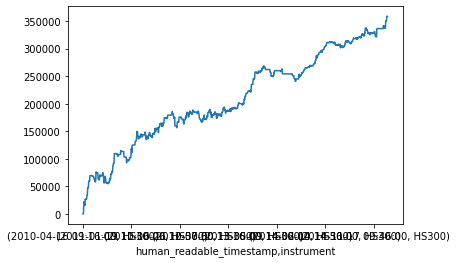

In [157]:
df_hs300.pnl_tally.cumsum().plot()

<AxesSubplot:>

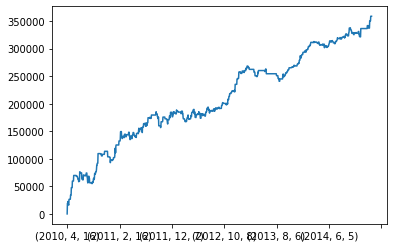

In [161]:
df_hs300.groupby(grouping).sum().pnl_tally.cumsum().plot()

In [106]:
sum(df_hs300.trade_size.abs())

1036.0

In [122]:
df_hs300.position_open.describe()

count    314280.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: position_open, dtype: float64

In [98]:
df_hs300[df_hs300.index.get_level_values('human_readable_timestamp') >= end_of_obs_time].index[0]

(Timestamp('2015-01-30 10:06:00'), 'HS300')

In [100]:
df_hs300.loc[df_hs300[df_hs300.index.get_level_values('human_readable_timestamp') >= end_of_obs_time].index[0], 
            'trade_signal_trade_allowed_intraday'] = 4

In [101]:
df_hs300.loc[df_hs300[df_hs300.index.get_level_values('human_readable_timestamp') >= end_of_obs_time].index[0], 
            'trade_signal_trade_allowed_intraday']

4.0

In [590]:
pd.to_datetime('2015-01-30 09:16:00') < g.index.get_level_values('human_readable_timestamp') and\
g.index.get_level_values('human_readable_timestamp') < pd.to_datetime('2015-01-30 15:07:00')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [597]:
intraday_trading_time_range(g.index.get_level_values('human_readable_timestamp'),
                            start = pd.to_datetime('2015-01-30 09:55:00'))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [598]:
intraday_drawdown_signal(g.open)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.70512675e-04,  0.00000000e+00, -4.54519630e-04, -7.95409352e-04,
       -4.54519630e-04, -7.38594398e-04, -1.24992898e-03, -9.65854213e-04,
       -3.97704676e-04,  0.00000000e+00, -6.24609619e-04, -7.94957697e-04,
       -1.02208847e-03, -7.94957697e-04, -2.83913463e-04, -5.67826926e-05,
        0.00000000e+00, -3.40271083e-04,  0.00000000e+00, -4.53540450e-04,
       -7.93695788e-04,  0.00000000e+00,  0.00000000e+00, -6.79732638e-04,
       -1.18953212e-03, -1.41610966e-03, -1.52939844e-03, -1.81262037e-03,
       -1.41610966e-03, -3.00215249e-03, -2.94550810e-03, -3.22873003e-03,
       -2.09584230e-03, -1.98255353e-03, -3.05879687e-03, -2.71893055e-03,
       -3.73852951e-03, -2.71893055e-03, -1.86926476e-03, -3.28537442e-03,
       -3.62524074e-03, -4.87141724e-03, -4.07839583e-03, -4.30497338e-03,
       -3.79517390e-03, -5.09799479e-03, -5.94766059e-03, -5.21128356e-03,
       -5.83437181e-03, -

In [585]:
pd.to_datetime('2015-01-30 09:16:00')

Timestamp('2015-01-30 09:16:00')

<AxesSubplot:xlabel='human_readable_timestamp,instrument'>

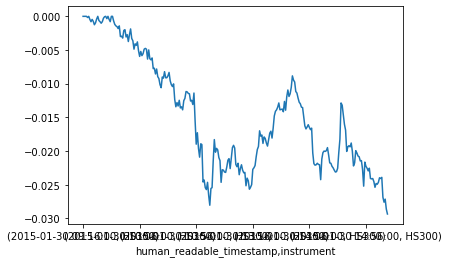

In [573]:
((g.open-previous_peaks)/previous_peaks).plot()

In [574]:
((g.open-previous_peaks)/previous_peaks)

human_readable_timestamp  instrument
2015-01-30 09:16:00       HS300         0.000000
2015-01-30 09:17:00       HS300         0.000000
2015-01-30 09:18:00       HS300         0.000000
2015-01-30 09:19:00       HS300         0.000000
2015-01-30 09:20:00       HS300        -0.000171
                                          ...   
2015-01-30 15:11:00       HS300        -0.026849
2015-01-30 15:12:00       HS300        -0.027586
2015-01-30 15:13:00       HS300        -0.027133
2015-01-30 15:14:00       HS300        -0.028605
2015-01-30 15:15:00       HS300        -0.029342
Name: open, Length: 270, dtype: float64

In [261]:
class Configuration:
    # 文件地址
    file_path = "data.csv"

    # 情绪平稳度阈值
    emotional_stability_threshold = 9 / 10000.0

    # 止损阈值
    stop_loss_threshold = 0.5 / 100.0

    # 初始金额
    # 设置为100是因为算到最后的结果刚好可以以百分比表示
    init_money = 100

    # 多次开仓交易的数据
    # money保存的是交易当前的金额
    # details保存的是所有的交易数据
    multi_transaction_data = dict(money=init_money, details=[])

    # 一次开仓交易的数据
    # money保存的是交易当前的金额
    # details保存的是所有的交易数据
    uni_transaction_data = dict(money=init_money, details=[])

    # 交易成本(双边)
    # 在计算收益的时候需要去掉
    service_charge = 2 / 10000.0

    # 以日期分组的数据
    data_group_by_date = {}

    # 沪深300期货每天的收盘价列表
    hu_shen_300_date_close_price_list = []

    # 沪深300期货每天的日期列表
    hu_shen_300_date_list = []


import csv


# 以日期分组数据
def group_data_by_date(file_path):
    # 从csv文件读取内容
    file = open(file_path, "r")
    line_list = csv.reader(file)

    # 保存以日期分组之后的内容
    data_group_by_date = Configuration.data_group_by_date

    # 不处理第一行字段
    index = 0

    # 遍历每一行内容
    for line in line_list:

        # 第一行数据是字段名称，不用处理
        index = index + 1
        if index == 1:
            continue

        # 把每一行数据转换成对象
        csv_data = dict(date=line[0], open=float(line[1]), close=float(line[2]), high=float(line[3]),
                        low=float(line[4]),
                        volume=int(float(line[5])), money=int(float(line[6])))

        # 截取日期，格式为年/月/日
        csv_date = line[0]
        csv_date = csv_date.split(" ")[0]

        # list保存一个日期的所有数据
        # 第一步先判断有没有保存这个日期的数据
        # 如果没有则初始化为空的数组
        # 如果有则拿出来
        if csv_date in data_group_by_date.keys():
            csv_data_list = data_group_by_date[csv_date]
        else:
            csv_data_list = []

        # 保存数据
        csv_data_list.append(csv_data)
        data_group_by_date[csv_date] = csv_data_list

    # 释放文件资源
    file.close()

    # 计算保存沪深300期货所有的日期和收盘价数据
    hu_shen_300_date_close_price_list = Configuration.hu_shen_300_date_close_price_list
    hu_shen_300_date_list = Configuration.hu_shen_300_date_list

    for date in data_group_by_date:
        data_of_date = data_group_by_date[date]  # 每天的数据
        len_of_data_of_date = len(data_of_date)
        close = data_of_date[len_of_data_of_date - 1]["close"]  # 沪深300期货每天的收盘价
        hu_shen_300_date_list.append(date)
        hu_shen_300_date_close_price_list.append(close)

    print("沪深300期货所有的日期列表：")
    print(hu_shen_300_date_list)

    print("沪深300期货每天所有的收盘价数据：")
    print(hu_shen_300_date_close_price_list)


def calculate_emotional_stability(data):
    length_of_data = len(data)

    max_sum = 0.0  # 最大回撤求和
    min_sum = 0.0  # 反向最大回撤求和
    for i_value in range(0, length_of_data):
        close_i = data[i_value]["close"]
        max_value = 0.0  # 计算一分钟的最大回撤
        min_value = 0.0  # 计算一分钟的反向最大回撤
        for j_value in range(i_value + 1, length_of_data):
            close_j = data[j_value]["close"]

            calculate_result = 1 - close_j / close_i

            if calculate_result > max_value:
                max_value = calculate_result

            if calculate_result < min_value:
                min_value = calculate_result

        max_sum += max_value  # 把每一分钟的最大回撤相加
        min_sum += -min_value  # 把每一分钟的反向最大回撤相加（注意取负值）

    max_ave = max_sum / length_of_data  # 平均最大回撤
    min_ave = min_sum / length_of_data  # 平均最大反向回撤

    print("平均最大回撤：" + str(max_ave))
    print("平均最大反向回撤：" + str(min_ave))

    # 比较平均最大回撤和平均最大反向回撤，哪个小就返回哪个
    if max_ave <= min_ave:
        print("采用平均最大回撤作为平稳度")
        return max_ave
    else:
        print("采用平均最大反向回撤作为平稳度")
        return min_ave

    

In [262]:
# 绘制折线图
import matplotlib.pyplot as plt

# 绘制折线图
from matplotlib.ticker import MultipleLocator

# 绘制折线图
def draw_line_chart():
    # 从单次开仓交易数据中获取折线图的数据
    uni_line_chart_data = get_line_chart_data(Configuration.uni_transaction_data)
    uni_date_list = uni_line_chart_data["date_list"]
    uni_money_list = uni_line_chart_data["money_list"]

    # 从多次开仓交易数据中获取折线图的数据
    multi_line_chart_data = get_line_chart_data(Configuration.multi_transaction_data)
    multi_date_list = multi_line_chart_data["date_list"]
    multi_money_list = multi_line_chart_data["money_list"]

    plt.subplots_adjust(bottom=0.4)  # 调节下方位置，不然日期太长会被挡住

    '''
    plt.subplots_adjust(bottom=0.9)  # 调节下方位置，不然日期太长会被挡住
    plt.title("model cumulative income")  # 标题，模型累计收益
    plt.xlabel("date")  # x轴表示日期
    plt.ylabel("cumulative income")  # y轴表示累计收益

    # 把x轴的刻度间隔设置为40，并存在变量里
    x_major_locator = MultipleLocator(40)

    # ax为两条坐标轴的实例
    ax = plt.gca()

    # 把x轴的主刻度设置为40的倍数
    ax.xaxis.set_major_locator(x_major_locator)

    # x轴倾斜90度
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    '''

    # 开始绘制折线图

    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(111)
    ax1.xaxis.set_major_locator(MultipleLocator(30))
    for tick in ax1.get_xticklabels():
        tick.set_rotation(90)

    ax1.plot(multi_date_list, multi_money_list, color="blue")
    ax1.plot(uni_date_list, uni_money_list, color="gray")

    ax2 = ax1.twinx()  # this is the important function
    ax2.xaxis.set_major_locator(MultipleLocator(30))
    ax2.plot(Configuration.hu_shen_300_date_list, Configuration.hu_shen_300_date_close_price_list, color="orange")

    # 同时展示多条图表
    plt.legend()
    plt.show()


# 从交易数据中获取绘制折线图所需要的数据
def get_line_chart_data(transaction_data):
    # 保存x轴的数据 日期
    date_list = []

    # 保存y轴的数据 累计收益
    money_list = []

    for details in transaction_data["details"]:
        date_value = details["date"]
        money_value = details["money"]

        date_list.append(date_value)

        # 注意这里减去init_money非常必要，因为算的是累计收益，必须减去本金，不然会多100%
        money_list.append(money_value - Configuration.init_money)

    return dict(date_list=date_list, money_list=money_list)




In [263]:
# 计算一天的交易数据
# transaction_data 保存所有的交易数据
# date_value 日期
# date_init_list 一天所有的原始csv数据
# sample_observation_begin_index 样本观察开始索引
# sample_observation_end_index 样本观察结束索引
# finish_index 收盘平仓时的索引
def calculate_transaction_data(transaction_data, date_value, date_init_list, sample_observation_begin_index,
                               sample_observation_end_index, finish_index):
    # 根据样本观察索引区间获取样本数据
    sample_observation = date_init_list[sample_observation_begin_index:sample_observation_end_index]
    print("样本长度为：" + str(len(sample_observation)))

    # 根据样本数据计算情绪平稳度
    
    emotional_stability = calculate_emotional_stability(sample_observation)

    # 情绪平稳度小于阈值，决定开仓
    if emotional_stability < Configuration.emotional_stability_threshold:
        print("情绪平稳度小于阈值，决定开仓")

        # 样本观察收盘价
        sample_observation_end_close = date_init_list[sample_observation_end_index - 1]["close"]

        # 样本观察开盘价
        sample_observation_begin_open = date_init_list[sample_observation_begin_index]["open"]

        # 在样本观察之后的下一分钟开盘买入
        buy_price = date_init_list[sample_observation_end_index]["open"]
        print(f"开仓价格：{buy_price}")
        
        # 如果样本观察的收盘价大于样本观察开盘价，则做多
        if sample_observation_end_close > sample_observation_begin_open:
            print("开始做多")
            long = 1
        else:
            print("开始做空")
            long = 0

        for i_value in range(sample_observation_end_index + 1, finish_index):

            # 在开盘之后判断是否需要止损
            sell_price = date_init_list[i_value]["open"]

            # 如果做多，则用卖出价格减去买入价格
            if long == 1:
                percent = (sell_price - buy_price) / buy_price

            # 如果做空，则用买入价格减去卖出价格
            else:
                percent = (buy_price - sell_price) / buy_price

            # 如果损失大于止损阈值，则平仓止损
            if percent < 0 and abs(percent) > Configuration.stop_loss_threshold:
                print("平仓止损")

                transaction_data["money"] = transaction_data["money"] * (1 + percent - Configuration.service_charge)
                transaction_data["details"].append(
                    dict(date=date_value, money=transaction_data["money"]))
                return

        print("收盘平仓")
        sell_price = date_init_list[finish_index - 1]["open"]

        # 如果做多，则用卖出价格减去买入价格
        if long == 1:
            percent = (sell_price - buy_price) / buy_price

        # 如果做空，则用买入价格减去卖出价格
        else:
            percent = (buy_price - sell_price) / sell_price

        transaction_data["money"] = transaction_data["money"] * (1 + percent - Configuration.service_charge)
        transaction_data["details"].append(
            dict(date=date_value, money=transaction_data["money"]))
        return

    else:
        print("情绪平稳度大于阈值，决定不开仓")
        transaction_data["details"].append(dict(date=date_value, money=transaction_data["money"]))
        return




In [264]:
group_data_by_date(Configuration.file_path)
data_group_by_date = Configuration.data_group_by_date

for date in data_group_by_date.keys():
    print("开始处理日期" + date + "的数据")

    # 当前日期所有的初始数据
    date_csv_list = data_group_by_date[date]
    length = len(date_csv_list)
    #print("当前日期有" + str(length) + "条数据")

    # 早晨样本观察开始索引
    morning_sample_start = 0

    # 早晨样本观察结束索引
    morning_sample_end = 0

    # 早晨平仓索引
    morning_position_close = 0

    # 下午样本观察开始索引
    afternoon_sample_start = 0

    # 下午样本观察结束索引
    afternoon_sample_end = 0

    # 下午平仓索引
    afternoon_position_close = length

    # 多次开仓的交易策略中，上午开仓同原始策略一致，观察开盘后50分钟的收盘价样本，随后决定是否开仓。但是在11：30上午收市时平仓。下午开盘则充分利用上午的数据，观察包括上午收盘数据在内11:12至13:32的数据样本，并在13:33决定下午是否开仓。
    # 遍历该日期对应的所有时间点，找出操作点对应的索引
    for i in range(0, length):
        i_date = date_csv_list[i]["date"]

        if i_date.endswith("9:16:00"):
            morning_sample_start = i

        if i_date.endswith("10:06:00"):
            morning_sample_end = i

        if i_date.endswith("11:30:00"):
            morning_position_close = i

        if i_date.endswith("11:12:00"):
            afternoon_sample_start = i

        if i_date.endswith("13:32:00"):
            afternoon_sample_end = i

    # 多次开仓 --> 早晨开仓
    print("----------------------------------------")
    print("多次开仓 --> 早晨开仓，开始处理......")
    calculate_transaction_data(Configuration.multi_transaction_data, date, date_csv_list,
                                                 morning_sample_start,
                                                 morning_sample_end, morning_position_close + 1)

    # 多次开仓 --> 下午开仓
    print("----------------------------------------")
    print("多次开仓 --> 下午开仓，开始处理......")
    calculate_transaction_data(Configuration.multi_transaction_data, date, date_csv_list,
                                                 afternoon_sample_start,
                                                 afternoon_sample_end, afternoon_position_close)

    # 一次开仓
    print("----------------------------------------")
    print("一次开仓，开始处理......")
    calculate_transaction_data(Configuration.uni_transaction_data, date, date_csv_list,
                                                 morning_sample_start, morning_sample_end, afternoon_position_close)


沪深300期货所有的日期列表：
['2010-04-16', '2010-04-19', '2010-04-20', '2010-04-21', '2010-04-22', '2010-04-23', '2010-04-26', '2010-04-27', '2010-04-28', '2010-04-29', '2010-04-30', '2010-05-04', '2010-05-05', '2010-05-06', '2010-05-07', '2010-05-10', '2010-05-11', '2010-05-12', '2010-05-13', '2010-05-14', '2010-05-17', '2010-05-18', '2010-05-19', '2010-05-20', '2010-05-21', '2010-05-24', '2010-05-25', '2010-05-26', '2010-05-27', '2010-05-28', '2010-05-31', '2010-06-01', '2010-06-02', '2010-06-03', '2010-06-04', '2010-06-07', '2010-06-08', '2010-06-09', '2010-06-10', '2010-06-11', '2010-06-17', '2010-06-18', '2010-06-21', '2010-06-22', '2010-06-23', '2010-06-24', '2010-06-25', '2010-06-28', '2010-06-29', '2010-06-30', '2010-07-01', '2010-07-02', '2010-07-05', '2010-07-06', '2010-07-07', '2010-07-08', '2010-07-09', '2010-07-12', '2010-07-13', '2010-07-14', '2010-07-15', '2010-07-16', '2010-07-19', '2010-07-20', '2010-07-21', '2010-07-22', '2010-07-23', '2010-07-26', '2010-07-27', '2010-07-28', '20

采用平均最大回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.001247237088755997
平均最大反向回撤：0.0034549042620674484
采用平均最大回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.006072711934919051
平均最大反向回撤：0.006454089548381319
采用平均最大回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
开始处理日期2010-07-16的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.002073090000050588
平均最大反向回撤：0.002297002936788668
采用平均最大回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0022687820016551253
平均最大反向回撤：0.001784684040575173
采用平均最大反向回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.002073090000050588
平均最大反向回撤：0.002297002936788668
采用平均最大回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
开始处理日期2010-07-19的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.00041486585420336786
平均最大反向回撤：0.0056571931744

开始处理日期2010-10-13的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0014876592463851357
平均最大反向回撤：0.003874998368720104
采用平均最大回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0007590203359998982
平均最大反向回撤：0.0032570173346286556
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：3204.4
开始做多
收盘平仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0014876592463851357
平均最大反向回撤：0.003874998368720104
采用平均最大回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
开始处理日期2010-10-14的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0018084758655201939
平均最大反向回撤：0.002271957860242426
采用平均最大回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0009472068038593729
平均最大反向回撤：0.002547685932623809
采用平均最大回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0018084758655201939
平均最大反向回撤：0.002271957860242426
采用

平均最大回撤：0.0040434548752497634
平均最大反向回撤：0.001529824171446279
采用平均最大反向回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
开始处理日期2011-01-07的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0016841821295081494
平均最大反向回撤：0.0008433837922508669
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：3191.0
开始做多
收盘平仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0013138013704000829
平均最大反向回撤：0.002128098124311042
采用平均最大回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0016841821295081494
平均最大反向回撤：0.0008433837922508669
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：3191.0
开始做多
平仓止损
开始处理日期2011-01-10的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0016463300494954946
平均最大反向回撤：0.004025238568064387
采用平均最大回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0033342842344888358
平均最大反向回撤：0.0006397771335934044
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：318

情绪平稳度小于阈值，决定开仓
开仓价格：3329.8
开始做多
收盘平仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.001595726696210571
平均最大反向回撤：0.00452753981078339
采用平均最大回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
开始处理日期2011-04-07的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0009566521633482395
平均最大反向回撤：0.0005894440449761263
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：3326.0
开始做空
收盘平仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0003464497699406288
平均最大反向回撤：0.0020215683539657903
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：3337.6
开始做多
收盘平仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0009566521633482395
平均最大反向回撤：0.0005894440449761263
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：3326.0
开始做空
收盘平仓
开始处理日期2011-04-08的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0007084737990465073
平均最大反向回撤：0.0035762184073953973
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：3349.0
开始做多
收盘平仓
-------------------------------

开始处理日期2011-06-22的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0006544013210445154
平均最大反向回撤：0.0005432769835178241
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2907.8
开始做空
收盘平仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0021860064270571855
平均最大反向回撤：0.0004244722906015852
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2888.4
开始做空
平仓止损
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0006544013210445154
平均最大反向回撤：0.0005432769835178241
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2907.8
开始做空
收盘平仓
开始处理日期2011-06-23的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.00088925821076417
平均最大反向回撤：0.0007942068439322814
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2890.6
开始做空
平仓止损
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.000641857385370228
平均最大反向回撤：0.001508866074973021
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2919.6
开始做多
收盘平仓
-----------------------------------

开始做空
收盘平仓
开始处理日期2011-09-07的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.002293678397022256
平均最大反向回撤：0.0006763042136196651
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2745.4
开始做空
平仓止损
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.00045601309217301544
平均最大反向回撤：0.00621256333890758
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2781.2
开始做多
平仓止损
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.002293678397022256
平均最大反向回撤：0.0006763042136196651
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2745.4
开始做空
平仓止损
开始处理日期2011-09-08的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0018187498771552169
平均最大反向回撤：0.0012629346743396575
采用平均最大反向回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0010004917659092749
平均最大反向回撤：0.0004545090134365548
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2783.8
开始做空
收盘平仓
----------------------------------------
一次开仓

平仓止损
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0032837530921958915
平均最大反向回撤：0.002393537644538326
采用平均最大反向回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
开始处理日期2011-12-05的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.006784436511141248
平均最大反向回撤：0.0008781003426612655
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2548.8
开始做空
平仓止损
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0017050145349230262
平均最大反向回撤：0.00241948278457472
采用平均最大回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.006784436511141248
平均最大反向回撤：0.0008781003426612655
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2548.8
开始做空
平仓止损
开始处理日期2011-12-06的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0009572800806520254
平均最大反向回撤：0.00202378735505099
采用平均最大回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0021376595027640466
平均最

平均最大回撤：0.0002028363452879689
平均最大反向回撤：0.0029656367751902477
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2669.4
开始做多
收盘平仓
开始处理日期2012-03-05的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0008841181034648393
平均最大反向回撤：0.0013411954345381228
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2699.2
开始做多
收盘平仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.002188853491833156
平均最大反向回撤：0.00044918332812710293
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2688.0
开始做空
收盘平仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0008841181034648393
平均最大反向回撤：0.0013411954345381228
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2699.2
开始做多
平仓止损
开始处理日期2012-03-06的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.003165004567611911
平均最大反向回撤：0.00032511679843899355
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2664.2
开始做空
收盘平仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0027673379541256794
平均最大反向

开仓价格：2608.6
开始做多
平仓止损
开始处理日期2012-05-24的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0008999673217262028
平均最大反向回撤：0.002707858772263134
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2605.4
开始做多
平仓止损
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.003483101541364757
平均最大反向回撤：0.0003447535922370015
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2575.8
开始做空
平仓止损
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0008999673217262028
平均最大反向回撤：0.002707858772263134
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2605.4
开始做多
平仓止损
开始处理日期2012-05-25的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0009361514262757376
平均最大反向回撤：0.0016739737836678438
采用平均最大回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0015177783465206618
平均最大反向回撤：0.0008528666134692608
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2567.4
开始做空
收盘平仓
-------------------------------------

多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0004662269872005642
平均最大反向回撤：0.0022544668309976636
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2382.0
开始做多
收盘平仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.00034026539093111595
平均最大反向回撤：0.003019812484280906
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2391.8
开始做多
收盘平仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0004662269872005642
平均最大反向回撤：0.0022544668309976636
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2382.0
开始做多
收盘平仓
开始处理日期2012-08-07的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0004881200096630178
平均最大反向回撤：0.0010332254084001846
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2403.0
开始做多
收盘平仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0005095352029615107
平均最大反向回撤：0.000714720669641622
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2402.6
开始做多
收盘平仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0004881200096630178
平均最大反向

收盘平仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0004794179435661294
平均最大反向回撤：0.0015063962440586165
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2336.8
开始做空
收盘平仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.003052586902111711
平均最大反向回撤：0.00042989178290637754
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2346.4
开始做空
收盘平仓
开始处理日期2012-10-24的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.000497715291028975
平均最大反向回撤：0.001956717576844329
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2323.8
开始做多
收盘平仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0012668972787487575
平均最大反向回撤：0.0008082248660618108
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2330.8
开始做多
收盘平仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.000497715291028975
平均最大反向回撤：0.001956717576844329
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2323.8
开始做多
收盘平仓
开始处理日期2012-10-25的数据
----------------------------------------
多次

开始处理日期2012-12-27的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.007282586041907127
平均最大反向回撤：0.002992305879954209
采用平均最大反向回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0008727862544034837
平均最大反向回撤：0.001327613896885631
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2467.8
开始做多
收盘平仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.007282586041907127
平均最大反向回撤：0.002992305879954209
采用平均最大反向回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
开始处理日期2012-12-28的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0015654491114540647
平均最大反向回撤：0.00098024482222554
采用平均最大反向回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0004056301239086069
平均最大反向回撤：0.003985266562732836
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2482.4
开始做多
收盘平仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0015654491114540647
平均最大反向回撤：

一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.001751002502324579
平均最大反向回撤：0.0024833372245340523
采用平均最大回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
开始处理日期2013-03-20的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0008461491185312142
平均最大反向回撤：0.010741857375844925
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2566.2
开始做多
收盘平仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.00431601941719993
平均最大反向回撤：0.0021661784228620374
采用平均最大反向回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0008461491185312142
平均最大反向回撤：0.010741857375844925
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2566.2
开始做多
收盘平仓
开始处理日期2013-03-21的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0013460900932507846
平均最大反向回撤：0.0034975089989413275
采用平均最大回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0014813832272705452
平均最大反向回撤：0.0013233532515212066
采用平均最大反向回撤作为平稳度
情绪平稳

平均最大反向回撤：0.0010926427814715867
采用平均最大反向回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0030447907400262377
平均最大反向回撤：0.0012936692251570613
采用平均最大反向回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0030380593192704474
平均最大反向回撤：0.0010926427814715867
采用平均最大反向回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
开始处理日期2013-06-20的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0031627573483632297
平均最大反向回撤：0.0017494563192316814
采用平均最大反向回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.004830842060309561
平均最大反向回撤：0.0007930248583810063
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2322.8
开始做空
收盘平仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0031627573483632297
平均最大反向回撤：0.0017494563192316814
采用平均最大反向回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
开始处理日期2013-06-21的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理.

多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0025488076332621777
平均最大反向回撤：0.0008077359995281386
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2502.0
开始做空
收盘平仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0003404412574606308
平均最大反向回撤：0.004091743302511572
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2498.0
开始做多
平仓止损
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0025488076332621777
平均最大反向回撤：0.0008077359995281386
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2502.0
开始做空
收盘平仓
开始处理日期2013-09-17的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0019271255773353646
平均最大反向回撤：0.000709873186139669
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2476.8
开始做空
收盘平仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0027801480116844777
平均最大反向回撤：0.000417058765234537
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2462.8
开始做空
收盘平仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0019271255773353646


采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2428.6
开始做多
收盘平仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.00023898383613180974
平均最大反向回撤：0.001205337107581963
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2429.8
开始做多
收盘平仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0008668002345480085
平均最大反向回撤：0.0017482891641705134
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2428.6
开始做多
收盘平仓
开始处理日期2013-12-13的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0007317725571189793
平均最大反向回撤：0.005001280590267689
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2417.0
开始做多
收盘平仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0026589919597190814
平均最大反向回撤：0.000902634932186941
采用平均最大反向回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0007317725571189793
平均最大反向回撤：0.005001280590267689
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2417.0
开始做多
收盘平仓
开始处理日期2013-12-16的数据
-------------------

平均最大回撤：0.001212296764782057
平均最大反向回撤：0.0007862749387248424
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2286.2
开始做空
收盘平仓
开始处理日期2014-02-24的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.005343865947975503
平均最大反向回撤：0.0006952734514663561
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2213.8
开始做空
收盘平仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0006667016673082804
平均最大反向回撤：0.0015006669903404558
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2203.8
开始做多
收盘平仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.005343865947975503
平均最大反向回撤：0.0006952734514663561
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2213.8
开始做空
收盘平仓
开始处理日期2014-02-25的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.002684622244445547
平均最大反向回撤：0.0017815741612372494
采用平均最大反向回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0030927971768070117
平均最大反向回撤：0.0005904191997713

平均最大回撤：0.0009535327999696585
平均最大反向回撤：0.0017583671179227966
采用平均最大回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0033302665081599535
平均最大反向回撤：0.0009220790313183035
采用平均最大反向回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
开始处理日期2014-05-13的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0003924091110044392
平均最大反向回撤：0.000923654936809446
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2171.8
开始做空
收盘平仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0017302465471406014
平均最大反向回撤：0.0002699758892634074
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2163.0
开始做空
收盘平仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0003924091110044392
平均最大反向回撤：0.000923654936809446
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2171.8
开始做空
收盘平仓
开始处理日期2014-05-14的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.000992418944630753
平均最大反向回撤：0.0009002593238558454
采用平均最大反向回撤作为平稳度
情绪平稳度大于阈值，决定不

平均最大回撤：0.0015835126065375448
平均最大反向回撤：0.0003045004182185007
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2153.8
开始做空
收盘平仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0008326034969633022
平均最大反向回撤：0.000925897549413377
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2159.6
开始做空
收盘平仓
开始处理日期2014-07-22的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0003039925550683087
平均最大反向回撤：0.004318559708409681
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2167.6
开始做多
收盘平仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.0015126102503033834
平均最大反向回撤：0.0007376895429484609
采用平均最大反向回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2189.4
开始做空
收盘平仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0003039925550683087
平均最大反向回撤：0.004318559708409681
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2167.6
开始做多
收盘平仓
开始处理日期2014-07-23的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0005199272892907025
平均最大反向回撤：0.0027235

----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0005797408627159495
平均最大反向回撤：0.003220254209941409
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2399.6
开始做多
收盘平仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.000628811407466432
平均最大反向回撤：0.002849133398947421
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2410.8
开始做多
收盘平仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0005797408627159495
平均最大反向回撤：0.003220254209941409
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2399.6
开始做多
收盘平仓
开始处理日期2014-09-24的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0003379776602450391
平均最大反向回撤：0.0042545887845687825
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2412.8
开始做多
收盘平仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.00046870051634512633
平均最大反向回撤：0.006405961211832345
采用平均最大回撤作为平稳度
情绪平稳度小于阈值，决定开仓
开仓价格：2455.2
开始做多
收盘平仓
----------------------------------------
一次开仓，开始处理......
样本长度为：

情绪平稳度大于阈值，决定不开仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.007566195591801517
平均最大反向回撤：0.003936033079224624
采用平均最大反向回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.006212375579991267
平均最大反向回撤：0.006301892937698383
采用平均最大回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
开始处理日期2014-12-11的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0013528401060962803
平均最大反向回撤：0.008841920087185397
采用平均最大回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
多次开仓 --> 下午开仓，开始处理......
样本长度为：50
平均最大回撤：0.009981519306788785
平均最大反向回撤：0.003103301663100666
采用平均最大反向回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
----------------------------------------
一次开仓，开始处理......
样本长度为：50
平均最大回撤：0.0013528401060962803
平均最大反向回撤：0.008841920087185397
采用平均最大回撤作为平稳度
情绪平稳度大于阈值，决定不开仓
开始处理日期2014-12-12的数据
----------------------------------------
多次开仓 --> 早晨开仓，开始处理......
样本长度为：50
平均最大回撤：0.0019789222214073245
平均最大反向回撤：0.0032734017594150356
采用平均最大

In [252]:
df_hs300x[df_hs300x.trade_size != 0]

,,open,close,high,low,trade_size,trade_price
human_readable_timestamp,instrument,,,,,,
2010-04-16 13:33:00,HS300,3431.0,3431.8,3431.8,3431.0,-1.0,3431.0
2010-04-16 14:11:00,HS300,3448.2,3445.8,3448.6,3445.6,1.0,3448.2
2010-04-19 13:33:00,HS300,3294.0,3294.0,3294.8,3291.2,-1.0,3294.0
2010-04-19 15:15:00,HS300,3197.6,3197.4,3198.6,3197.0,1.0,3197.6
2010-04-20 13:33:00,HS300,3175.0,3175.0,3175.8,3174.2,-1.0,3175.0
...,...,...,...,...,...,...,...
2015-01-22 13:56:00,HS300,3549.4,3554.4,3554.8,3549.4,-1.0,3549.4
2015-01-27 13:33:00,HS300,3531.2,3536.2,3536.4,3530.8,-1.0,3531.2
2015-01-27 13:59:00,HS300,3565.8,3570.0,3570.0,3562.0,1.0,3565.8


In [268]:
signal_df

average_drawdown  average_reverse_drawdown  \
date       trading_start_time                                               
2010-04-16 10:06:00                    0.001905                  0.001064   
           13:33:00                    0.000499                  0.000142   
2010-04-19 10:06:00                    0.002173                  0.000232   
           13:33:00                    0.004805                  0.000601   
2010-04-20 10:06:00                    0.002883                  0.002430   
...                                         ...                       ...   
2015-01-28 13:33:00                    0.000688                  0.009618   
2015-01-29 10:06:00                    0.001213                  0.005335   
           13:33:00                    0.004508                  0.003225   
2015-01-30 10:06:00                    0.003122                  0.001573   
           13:33:00                    0.002366                  0.004254   

                               emotional_index  
date       trading_start_time                   
2010-04-16 10:06:00                   0.001064  
           13:33:00                   0.000142  
2010-04-19 10:06:00                   0.000232  
           13:33:00                   0.000601  
2010-04-20 10:06:00                   0.002430  
...                                        ...  
2015-01-28 13:33:00                   0.000688  
2015-01-29 10:06:00                   0.001213  
           13:33:00                   0.003225  
2015-01-30 10:06:00                   0.001573  
           13:33:00                   0.002366  

[2328 rows x 3 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 432x288 with 0 Axes>

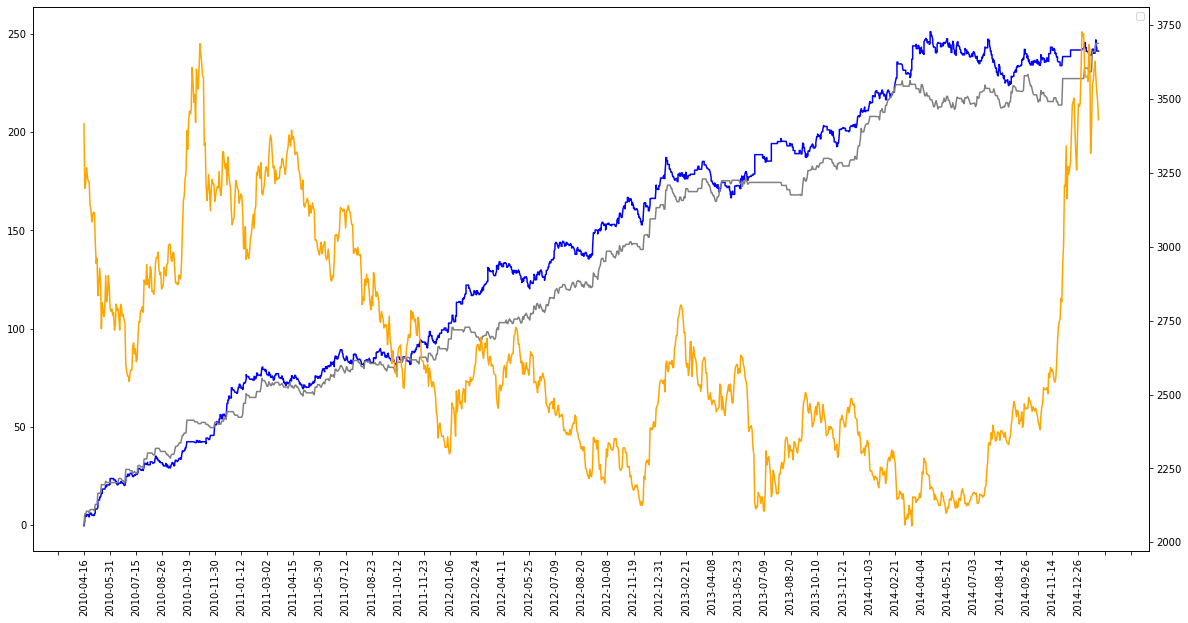

In [150]:
draw_line_chart()

In [554]:
pd.DataFrame(Configuration.uni_transaction_data)

,money,details
0,362.472253,"{'date': '2010-04-16', 'money': 100}"
1,362.472253,"{'date': '2010-04-19', 'money': 105.6283392756..."
2,362.472253,"{'date': '2010-04-20', 'money': 105.6283392756..."
3,362.472253,"{'date': '2010-04-21', 'money': 107.0358634379..."
4,362.472253,"{'date': '2010-04-22', 'money': 107.0358634379..."
...,...,...
1159,362.472253,"{'date': '2015-01-26', 'money': 357.8586065114..."
1160,362.472253,"{'date': '2015-01-27', 'money': 362.4722534956..."
1161,362.472253,"{'date': '2015-01-28', 'money': 362.4722534956..."
1162,362.472253,"{'date': '2015-01-29', 'money': 362.4722534956..."


In [557]:
Configuration.uni_transaction_data

{'money': 362.4722534956233,
 'details': [{'date': '2010-04-16', 'money': 100},
  {'date': '2010-04-19', 'money': 105.62833927566146},
  {'date': '2010-04-20', 'money': 105.62833927566146},
  {'date': '2010-04-21', 'money': 107.03586343793998},
  {'date': '2010-04-22', 'money': 107.03586343793998},
  {'date': '2010-04-23', 'money': 107.03586343793998},
  {'date': '2010-04-26', 'money': 106.3357211834259},
  {'date': '2010-04-27', 'money': 107.77797613525269},
  {'date': '2010-04-28', 'money': 107.91510018738903},
  {'date': '2010-04-29', 'money': 107.91510018738903},
  {'date': '2010-04-30', 'money': 107.91510018738903},
  {'date': '2010-05-04', 'money': 107.91510018738903},
  {'date': '2010-05-05', 'money': 107.30992942411197},
  {'date': '2010-05-06', 'money': 110.53037334901256},
  {'date': '2010-05-07', 'money': 110.53037334901256},
  {'date': '2010-05-10', 'money': 110.53037334901256},
  {'date': '2010-05-11', 'money': 116.24149412060417},
  {'date': '2010-05-12', 'money': 116.241

In [717]:
xx = pd.DataFrame(get_line_chart_data(Configuration.uni_transaction_data))

In [718]:
xx

,date_list,money_list
0,2010-04-16,0.000000
1,2010-04-19,5.621731
2,2010-04-20,5.621731
3,2010-04-21,7.022614
4,2010-04-22,7.022614
...,...,...
1159,2015-01-26,262.668168
1160,2015-01-27,267.076774
1161,2015-01-28,267.076774
1162,2015-01-29,267.076774


In [559]:
yy+1

2010  4  16    1.000000
         19    1.052704
         20    1.000000
         21    1.012939
         22    1.000000
                 ...   
2015  1  26    1.000000
         27    1.011037
         28    1.000000
         29    1.000000
         30    1.000000
Name: pnl_net_perct, Length: 1164, dtype: float64

In [550]:
xx['money_list'].diff()[xx['money_list'].diff().values != 0]

0             NaN
1        5.628339
3        1.407524
6       -0.700142
7        1.442255
          ...    
1122    13.852942
1147     5.683079
1152    -1.840420
1156    10.084865
1160     4.613647
Name: money_list, Length: 544, dtype: float64

In [679]:
xx

,date_list,money_list
0,2010-04-16,0.000000
1,2010-04-19,5.628339
2,2010-04-20,5.628339
3,2010-04-21,7.035863
4,2010-04-22,7.035863
...,...,...
1159,2015-01-26,257.858607
1160,2015-01-27,262.472253
1161,2015-01-28,262.472253
1162,2015-01-29,262.472253


In [720]:
yy+1

2010  4  16    1.000000
         19    1.052704
         20    1.000000
         21    1.012939
         22    1.000000
                 ...   
2015  1  26    1.000000
         27    1.011037
         28    1.000000
         29    1.000000
         30    1.000000
Name: pnl_net_perct, Length: 1164, dtype: float64

In [721]:
1.052704*1.012939

1.0663249370560002

In [734]:
xx = pd.DataFrame(get_line_chart_data(Configuration.uni_transaction_data))
xx1 = xx.shift(1).values[:,1]
xx1[0] = 0.0
xx1 += 100.
xx1

array([100.0, 100.0, 105.62173129847385, ..., 367.07677365606855,
       367.07677365606855, 367.07677365606855], dtype=object)

In [735]:
xx.money_list += 100.
xx_pnl = xx.money_list / xx1

In [736]:
xx.money_list

0       100.000000
1       105.621731
2       105.621731
3       107.022614
4       107.022614
           ...    
1159    362.668168
1160    367.076774
1161    367.076774
1162    367.076774
1163    367.076774
Name: money_list, Length: 1164, dtype: float64

In [738]:
xx_pnl

0            1.0
1       1.056217
2            1.0
3       1.013263
4            1.0
          ...   
1159         1.0
1160    1.012156
1161         1.0
1162         1.0
1163         1.0
Name: money_list, Length: 1164, dtype: object

In [740]:
yy+1

2010  4  16    1.000000
         19    1.052704
         20    1.000000
         21    1.012939
         22    1.000000
                 ...   
2015  1  26    1.000000
         27    1.011037
         28    1.000000
         29    1.000000
         30    1.000000
Name: pnl_net_perct, Length: 1164, dtype: float64

In [755]:
df_analysis = pd.DataFrame(
    {
        'my_pnl': (yy).values,
        'another': (xx_pnl-1).values
        
    },
    index = xx.date_list)

In [756]:
df_analysis['diff'] = df_analysis.another - df_analysis.my_pnl

In [764]:
df_analysis[df_analysis['diff'] < 0]['diff'].min()

-0.013428135792820792

In [766]:
df_analysis[df_analysis['diff'] < -0.005]

,my_pnl,another,diff
date_list,,,
2010-07-27,0.000607,-0.005214,-0.005822
2010-11-19,0.002047,-0.008785,-0.010832
2010-11-23,0.001260,-0.005463,-0.006723
2011-01-07,0.000000,-0.006405,-0.006405
2011-02-23,0.000000,-0.006474,-0.006474
2011-03-01,0.000000,-0.00524,-0.00524
2011-04-07,0.002907,-0.003496,-0.006403
2011-04-27,0.008135,-0.005294,-0.013428
2011-07-11,0.000000,-0.005391,-0.005391
